<a href="https://colab.research.google.com/github/Shivcharan989/XploreDL/blob/main/Consumer_Complain_Classification_LSTM/Consumer_Complain_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import re
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
%matplotlib inline
from nltk.corpus import stopwords
import nltk
nltk.download("punkt")

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Activation, Dense, Dropout
from keras.layers import Bidirectional, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
df = pd.read_csv('consumer_complaints.csv')
df.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning:

Columns (4,5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282355 entries, 0 to 1282354
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1282355 non-null  object
 1   Product                       1282355 non-null  object
 2   Sub-product                   1047189 non-null  object
 3   Issue                         1282355 non-null  object
 4   Sub-issue                     751169 non-null   object
 5   Consumer complaint narrative  383564 non-null   object
 6   Company public response       449082 non-null   object
 7   Company                       1282355 non-null  object
 8   State                         1262955 non-null  object
 9   ZIP code                      1167057 non-null  object
 10  Tags                          175643 non-null   object
 11  Consumer consent provided?    690654 non-null   object
 12  Submitted via                 1282355 non-

In [55]:
df.sample()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
728266,04/11/2016,Credit card,NaN,APR or interest rate,NaN,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,92708,"Older American, Servicemember",NaN,Postal mail,04/13/2016,Closed with explanation,Yes,Yes,1873176


In [56]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(383564, 2)

In [57]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Credit reporting'],
       ['Credit card'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Other financial service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Virtual currency']], dtype=object)

In [58]:
# Renaming categories
df1.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


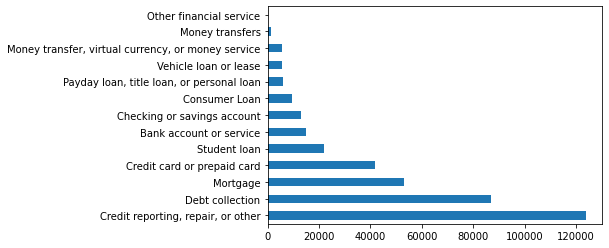

In [59]:
category_count = df1['Product'].value_counts().sort_values(ascending=False)
category_count.plot.barh()

In [60]:
df1.sample()

,Product,Consumer_complaint
339334,Student loan,I never went to that school


In [62]:
df1 = df1.loc[:170000]

In [63]:
df1 = df1.reset_index(drop=True)
symbols_rep_reg = re.compile('[/(){}\[\]\|@,;]')
bad_symbols_reg = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = symbols_rep_reg.sub(' ', text) # replace by space in text. substitute the matched string with space.
    text = bad_symbols_reg.sub('', text) # remove symbols which are  from text. substitute the matched string with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df1['Consumer_complaint'] = df1['Consumer_complaint'].apply(clean_text)
df1['Consumer_complaint'] = df1['Consumer_complaint'].str.replace('\d+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.



In [64]:
# The maximum number of words to be used is given here.
MAX_NB_WORDS = 50000
# Max number of words in each complaint is given here.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['Consumer_complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43350 unique tokens.


In [65]:
X = tokenizer.texts_to_sequences(df1['Consumer_complaint'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (55867, 250)


In [66]:
Y = pd.get_dummies(df1['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (55867, 9)


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(44693, 250) (44693, 9)
(11174, 250) (11174, 9)


In [68]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(125, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
629/629 [==============================] - 642s 1s/step - loss: 1.1423 - accuracy: 0.6144 - val_loss: 0.8739 - val_accuracy: 0.7148
Epoch 2/5
629/629 [==============================] - 634s 1s/step - loss: 0.7815 - accuracy: 0.7480 - val_loss: 0.7495 - val_accuracy: 0.7642
Epoch 3/5
629/629 [==============================] - 639s 1s/step - loss: 0.6368 - accuracy: 0.7972 - val_loss: 0.6929 - val_accuracy: 0.7776
Epoch 4/5
629/629 [==============================] - 634s 1s/step - loss: 0.4950 - accuracy: 0.8451 - val_loss: 0.6256 - val_accuracy: 0.8058
Epoch 5/5
629/629 [==============================] - 630s 1s/step - loss: 0.4984 - accuracy: 0.8524 - val_loss: 0.6970 - val_accuracy: 0.7812


In [69]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

350/350 [==============================] - 32s 91ms/step - loss: 0.7110 - accuracy: 0.7840
Test set
  Loss: 0.711
  Accuracy: 0.784


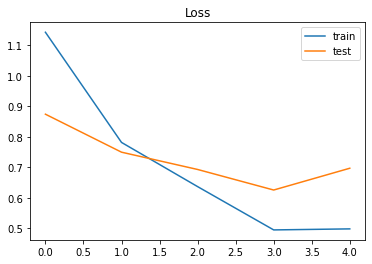

In [70]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

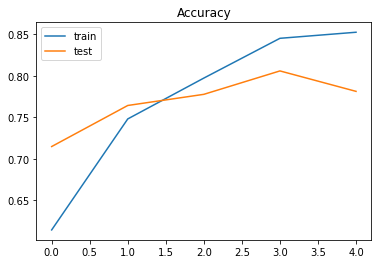

In [72]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [75]:
import numpy as np
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease']
print(pred, labels[np.argmax(pred)])

[[1.0121562e-04 3.6360719e-03 9.9086857e-01 4.3578199e-03 2.0881269e-05
  7.5048687e-05 8.0916994e-05 4.6075051e-04 3.9870336e-04]] Mortgage
